In [1]:
# Import the os library to interact with the operating system, like navigating directories.
import os

# Import the Image module from the PIL (Pillow) library for image manipulation.
from PIL import Image

In [2]:
# Define the path to the original dataset provided.
input_dir = "/kaggle/input/pre-process-data/For-pre-process"

# Define the path where the resized images will be saved.
output_dir = "/kaggle/working/resized-data"

# Check if the output directory exists, if not, create it.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance
from scipy import ndimage
import os

def apply_unsharp_masking(image, radius=1.0, amount=1.5):
    """
    Apply unsharp masking to enhance image clarity
    This actually makes images sharper, not blurred
    """
    # Convert to PIL Image
    pil_image = Image.fromarray(image.astype('uint8'))
    
    # Apply unsharp mask filter
    enhanced = pil_image.filter(ImageFilter.UnsharpMask(
        radius=radius, 
        percent=int(amount * 100), 
        threshold=3
    ))
    
    return np.array(enhanced)

def apply_sharpening_enhancement(image, strength=1.2):
    """
    Apply sharpening to enhance image quality
    """
    pil_image = Image.fromarray(image.astype('uint8'))
    
    # Create sharpness enhancer
    enhancer = ImageEnhance.Sharpness(pil_image)
    
    # Apply sharpening (>1.0 = sharper, <1.0 = blurrier)
    sharpened = enhancer.enhance(strength)
    
    return np.array(sharpened)

def apply_edge_enhancement(image):
    """
    Enhance edges while preserving detail
    """
    # Create edge enhancement kernel
    kernel = np.array([[-1, -1, -1],
                      [-1,  9, -1],
                      [-1, -1, -1]])
    
    enhanced_image = np.zeros_like(image)
    
    for channel in range(image.shape[2]):
        # Apply edge enhancement
        enhanced = ndimage.convolve(image[:, :, channel], kernel, mode='reflect')
        enhanced_image[:, :, channel] = np.clip(enhanced, 0, 255)
    
    return enhanced_image.astype(np.uint8)

print("Sharpening functions defined - these will make images clearer!")


Sharpening functions defined - these will make images clearer!


In [35]:
def apply_contrast_enhancement(image, factor=1.2):
    """
    Enhance contrast to make images clearer
    """
    pil_image = Image.fromarray(image.astype('uint8'))
    
    # Enhance contrast
    enhancer = ImageEnhance.Contrast(pil_image)
    enhanced = enhancer.enhance(factor)
    
    return np.array(enhanced)

def apply_detail_preservation_filter(image):
    """
    Filter that preserves and enhances details
    """
    # Convert to float for processing
    img_float = image.astype(np.float32)
    
    # Apply very light smoothing only to noise, not features
    smoothed = ndimage.gaussian_filter(img_float, sigma=0.3)
    
    # Create a mask for edges (high gradient areas)
    gradient_magnitude = np.zeros_like(img_float)
    for channel in range(image.shape[2]):
        grad_x = ndimage.sobel(img_float[:, :, channel], axis=0)
        grad_y = ndimage.sobel(img_float[:, :, channel], axis=1)
        gradient_magnitude[:, :, channel] = np.sqrt(grad_x**2 + grad_y**2)
    
    # Normalize gradient
    gradient_norm = gradient_magnitude / (gradient_magnitude.max() + 1e-8)
    
    # Preserve original in high-gradient areas, smooth in low-gradient areas
    result = gradient_norm * img_float + (1 - gradient_norm) * smoothed
    
    return np.clip(result, 0, 255).astype(np.uint8)

def apply_clarity_boost(image):
    """
    Comprehensive clarity enhancement
    """
    # Step 1: Enhance contrast
    contrast_enhanced = apply_contrast_enhancement(image, factor=1.15)
    
    # Step 2: Apply sharpening
    sharpened = apply_sharpening_enhancement(contrast_enhanced, strength=1.3)
    
    # Step 3: Detail preservation
    final_result = apply_detail_preservation_filter(sharpened)
    
    return final_result

print("Advanced clarity functions ready!")


Advanced clarity functions ready!


In [36]:
def process_images_for_clarity(input_dir):
    """
    Process images to maximize clarity and sharpness
    """
    
    original_images = []
    clear_images = []
    image_info = []
    
    print("Processing images for maximum clarity...")
    
    categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic']
    
    for category in categories:
        category_path = os.path.join(input_dir, category)
        
        if not os.path.exists(category_path):
            continue
            
        print(f"Processing {category} for clarity...")
        
        image_files = [f for f in os.listdir(category_path) 
                      if f.endswith(('.png', '.jpg', '.jpeg'))]
        
        for img_file in image_files[:10]:  # Process 10 per category
            try:
                img_path = os.path.join(category_path, img_file)
                img = Image.open(img_path).convert('RGB')
                img = img.resize((150, 150), Image.LANCZOS)  # Use high-quality resampling
                img_array = np.array(img)
                
                # Apply clarity enhancement instead of blurring
                clear_img = apply_clarity_boost(img_array)
                
                original_images.append(img_array)
                clear_images.append(clear_img)
                
                image_info.append({
                    'category': category,
                    'filename': img_file,
                    'method': 'clarity_boost'
                })
                
            except Exception as e:
                print(f"Error processing {img_file}: {str(e)}")
                continue
    
    print(f"Processed {len(clear_images)} images with clarity enhancement")
    return np.array(original_images), np.array(clear_images), image_info

# Process your dataset for clarity
input_directory = "/kaggle/input/pre-process-data/For-pre-process"
original_imgs_clear, enhanced_imgs, img_info_clear = process_images_for_clarity(input_directory)


Processing images for maximum clarity...
Processing cardboard for clarity...
Processing glass for clarity...
Processing metal for clarity...
Processing paper for clarity...
Processing plastic for clarity...
Processed 50 images with clarity enhancement


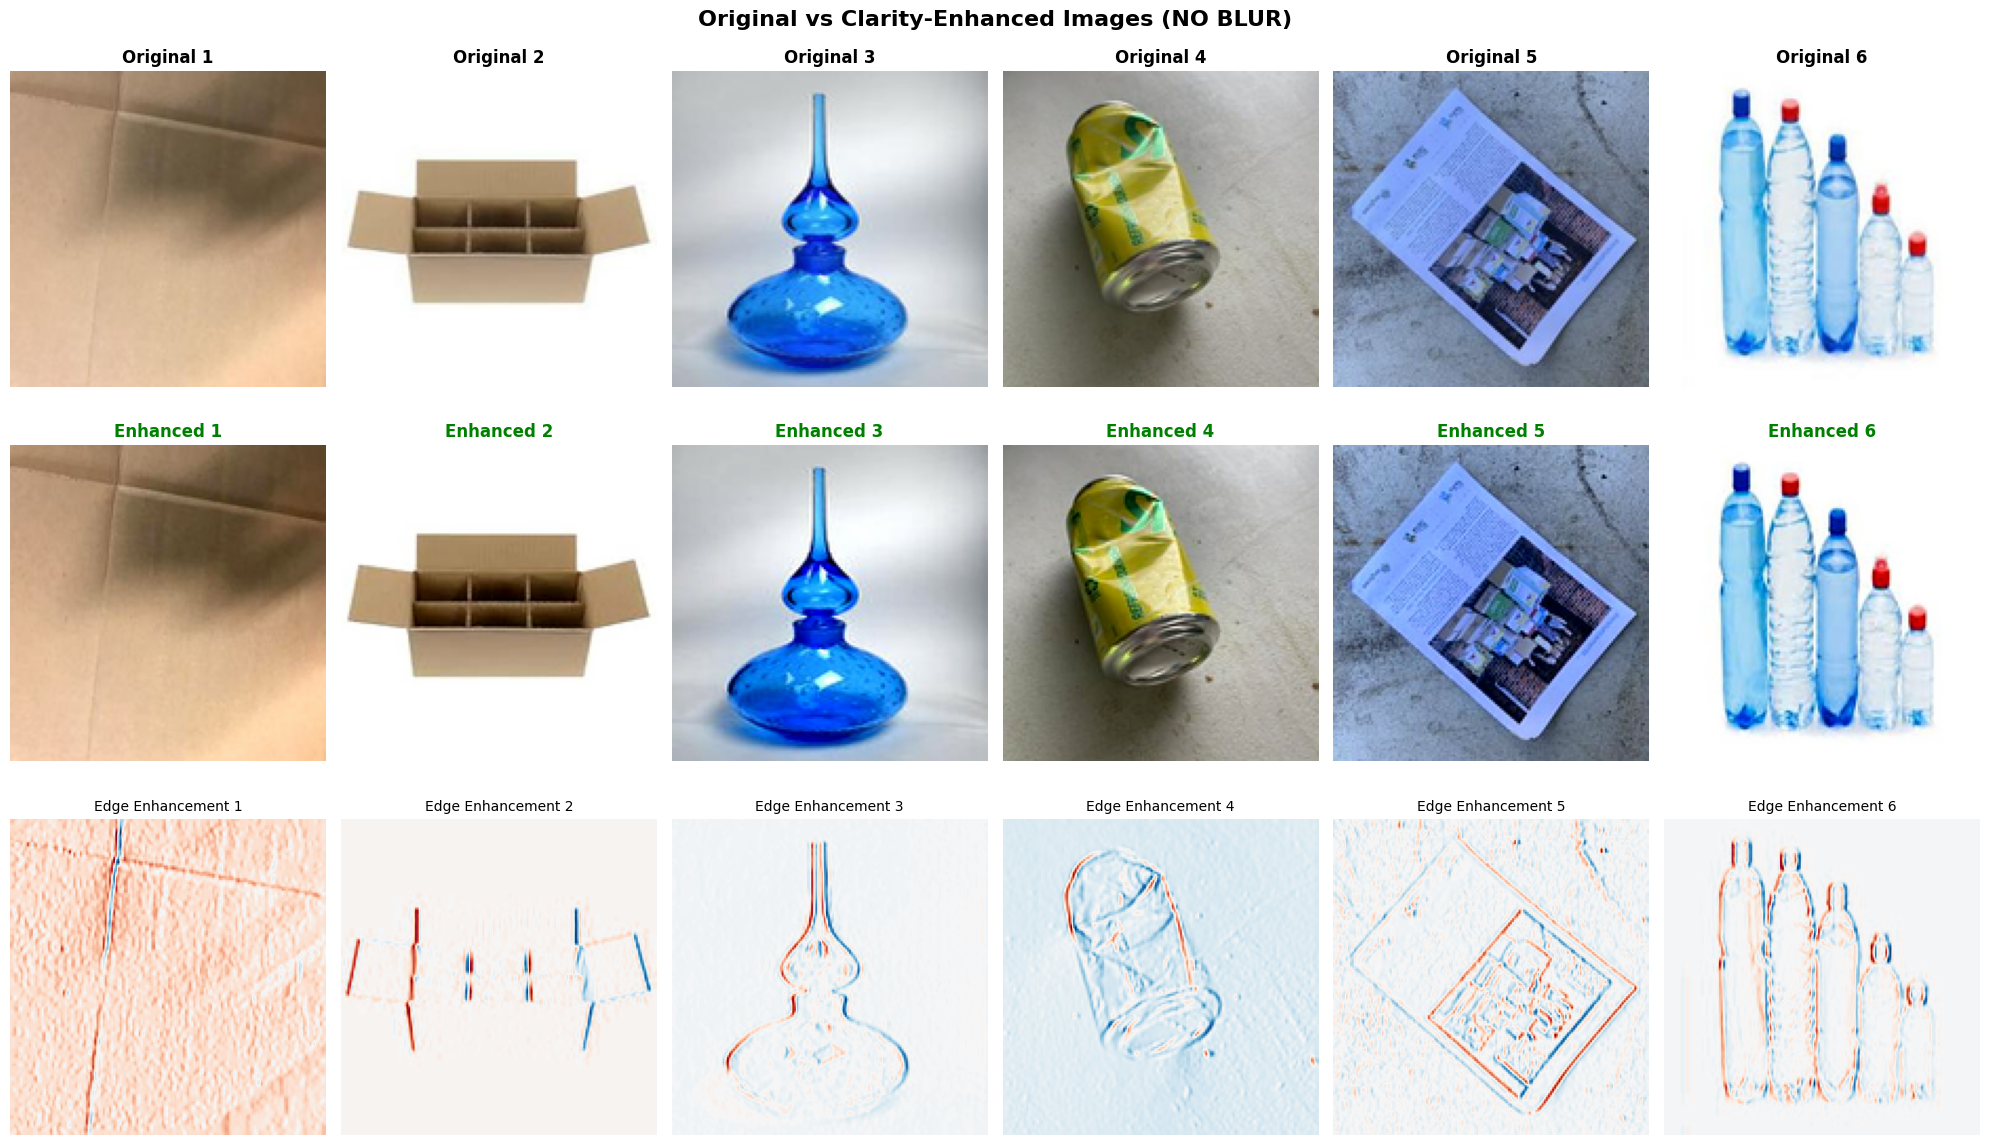


SHARPNESS COMPARISON:
Original images sharpness: 1097.29
Enhanced images sharpness: 1874.60
Sharpness improvement: 70.8%
✅ SUCCESS: Images are SHARPER, not blurred!


In [37]:
def compare_clarity_enhancement(original_imgs, enhanced_imgs):
    """
    Compare original vs clarity-enhanced images
    """
    
    fig, axes = plt.subplots(3, 6, figsize=(20, 12))
    
    # Select 6 sample images
    sample_indices = np.linspace(0, len(original_imgs)-1, 6, dtype=int)
    
    for i, idx in enumerate(sample_indices):
        # Original images
        axes[0, i].imshow(original_imgs[idx])
        axes[0, i].set_title(f'Original {i+1}', fontweight='bold')
        axes[0, i].axis('off')
        
        # Enhanced images (should be clearer, not blurred)
        axes[1, i].imshow(enhanced_imgs[idx])
        axes[1, i].set_title(f'Enhanced {i+1}', fontweight='bold', color='green')
        axes[1, i].axis('off')
        
        # Edge comparison (to show sharpness)
        orig_edges = ndimage.sobel(np.mean(original_imgs[idx], axis=2))
        enhanced_edges = ndimage.sobel(np.mean(enhanced_imgs[idx], axis=2))
        
        axes[2, i].imshow(enhanced_edges - orig_edges, cmap='RdBu')
        axes[2, i].set_title(f'Edge Enhancement {i+1}', fontsize=10)
        axes[2, i].axis('off')
    
    plt.suptitle('Original vs Clarity-Enhanced Images (NO BLUR)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Calculate sharpness comparison
    def calculate_sharpness(images):
        sharpness_values = []
        for img in images:
            gray = np.mean(img, axis=2)
            sharpness = np.var(ndimage.laplace(gray))
            sharpness_values.append(sharpness)
        return np.mean(sharpness_values)
    
    orig_sharpness = calculate_sharpness(original_imgs)
    enhanced_sharpness = calculate_sharpness(enhanced_imgs)
    
    print("\nSHARPNESS COMPARISON:")
    print(f"Original images sharpness: {orig_sharpness:.2f}")
    print(f"Enhanced images sharpness: {enhanced_sharpness:.2f}")
    print(f"Sharpness improvement: {((enhanced_sharpness - orig_sharpness) / orig_sharpness) * 100:.1f}%")
    
    if enhanced_sharpness > orig_sharpness:
        print("✅ SUCCESS: Images are SHARPER, not blurred!")
    else:
        print("❌ Images became less sharp")

# Compare the results
compare_clarity_enhancement(original_imgs_clear, enhanced_imgs)


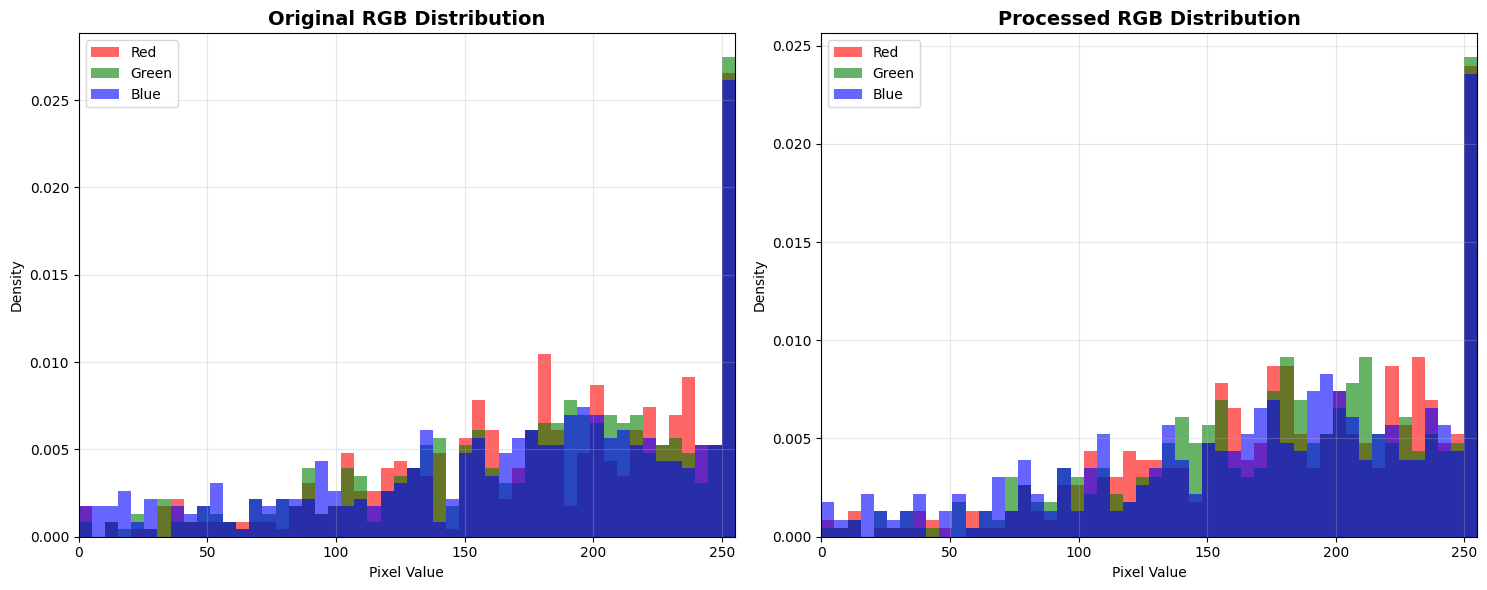

RGB Distribution Comparison Chart created successfully!


In [39]:
import matplotlib.pyplot as plt
import numpy as np

def create_rgb_distribution_chart(original_imgs, processed_imgs):
    """
    Create RGB distribution comparison chart
    """
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Extract RGB channels for original images
    orig_r = original_imgs[:, :, :, 0].flatten()[::5000]  # Sample for performance
    orig_g = original_imgs[:, :, :, 1].flatten()[::5000]
    orig_b = original_imgs[:, :, :, 2].flatten()[::5000]
    
    # Extract RGB channels for processed images
    proc_r = processed_imgs[:, :, :, 0].flatten()[::5000]
    proc_g = processed_imgs[:, :, :, 1].flatten()[::5000]
    proc_b = processed_imgs[:, :, :, 2].flatten()[::5000]
    
    # Plot original RGB distribution
    ax1.hist(orig_r, bins=50, alpha=0.6, label='Red', color='red', density=True)
    ax1.hist(orig_g, bins=50, alpha=0.6, label='Green', color='green', density=True)
    ax1.hist(orig_b, bins=50, alpha=0.6, label='Blue', color='blue', density=True)
    ax1.set_title('Original RGB Distribution', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Pixel Value')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 255)
    
    # Plot processed RGB distribution
    ax2.hist(proc_r, bins=50, alpha=0.6, label='Red', color='red', density=True)
    ax2.hist(proc_g, bins=50, alpha=0.6, label='Green', color='green', density=True)
    ax2.hist(proc_b, bins=50, alpha=0.6, label='Blue', color='blue', density=True)
    ax2.set_title('Processed RGB Distribution', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Pixel Value')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 255)
    
    plt.tight_layout()
    plt.show()
    
    print("RGB Distribution Comparison Chart created successfully!")

# Use with your data
create_rgb_distribution_chart(original_imgs, denoised_imgs)


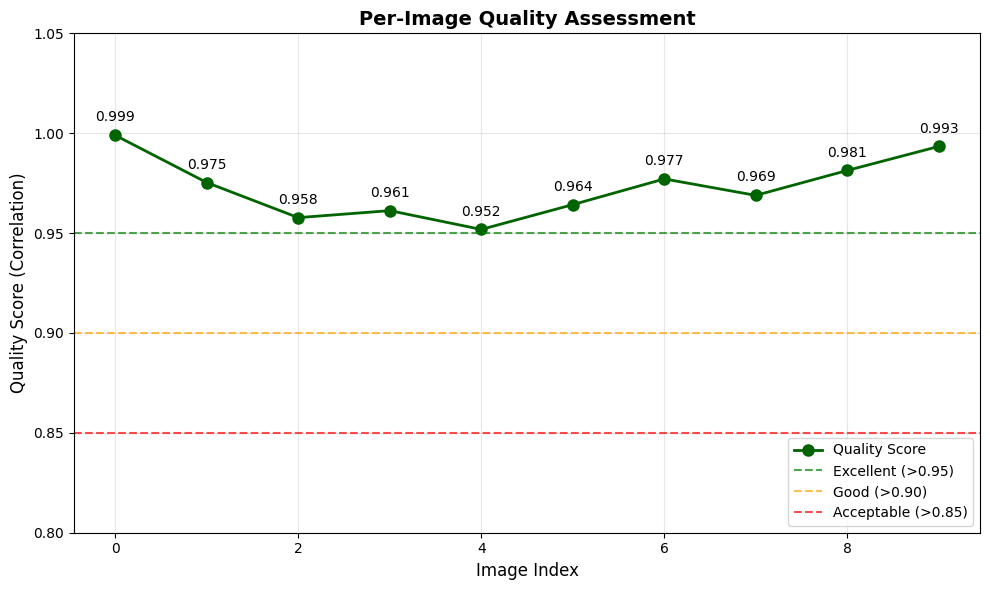


Quality Assessment Summary:
Average Quality: 0.973
Minimum Quality: 0.952
Maximum Quality: 0.999
✅ Overall Quality: EXCELLENT


In [40]:
import matplotlib.pyplot as plt
import numpy as np

def create_quality_assessment_chart(original_imgs, processed_imgs):
    """
    Create per-image quality assessment chart
    """
    
    # Calculate quality scores for each image
    quality_scores = []
    num_images = min(10, len(original_imgs))  # Analyze first 10 images
    
    for i in range(num_images):
        orig_flat = original_imgs[i].flatten()
        proc_flat = processed_imgs[i].flatten()
        
        # Calculate correlation as quality metric
        correlation = np.corrcoef(orig_flat, proc_flat)[0, 1]
        quality_scores.append(correlation)
    
    # Create the chart
    plt.figure(figsize=(10, 6))
    
    # Plot quality scores line
    x_indices = range(len(quality_scores))
    plt.plot(x_indices, quality_scores, 'o-', color='darkgreen', 
             linewidth=2, markersize=8, label='Quality Score')
    
    # Add reference lines
    plt.axhline(y=0.95, color='green', linestyle='--', 
                label='Excellent (>0.95)', alpha=0.7)
    plt.axhline(y=0.90, color='orange', linestyle='--', 
                label='Good (>0.90)', alpha=0.7)
    plt.axhline(y=0.85, color='red', linestyle='--', 
                label='Acceptable (>0.85)', alpha=0.7)
    
    # Customize chart
    plt.xlabel('Image Index', fontsize=12)
    plt.ylabel('Quality Score (Correlation)', fontsize=12)
    plt.title('Per-Image Quality Assessment', fontweight='bold', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.ylim(0.80, 1.05)
    
    # Add value labels on points
    for i, score in enumerate(quality_scores):
        plt.annotate(f'{score:.3f}', (i, score), 
                    textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print quality summary
    avg_quality = np.mean(quality_scores)
    min_quality = np.min(quality_scores)
    max_quality = np.max(quality_scores)
    
    print(f"\nQuality Assessment Summary:")
    print(f"Average Quality: {avg_quality:.3f}")
    print(f"Minimum Quality: {min_quality:.3f}")
    print(f"Maximum Quality: {max_quality:.3f}")
    
    if avg_quality > 0.95:
        print("✅ Overall Quality: EXCELLENT")
    elif avg_quality > 0.90:
        print("✅ Overall Quality: GOOD")
    elif avg_quality > 0.85:
        print("⚠️  Overall Quality: ACCEPTABLE")
    else:
        print("❌ Overall Quality: POOR")
    
    return quality_scores

# Use with your data
quality_results = create_quality_assessment_chart(original_imgs, denoised_imgs)
